# Описание проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

С помощью разведывательного анализа данных необходимо определить параметры для модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

# План:

1. Первичная обработка данных.
2. Корреляционный анализ количественных переменных, отбор не коррелирующих переменных.
3. Анализ распределения признака для числовых переменных, устранение выбросов для числовых переменных.
4. Оценка количества уникальных значений для номинативных переменных.
5. Преобразование данных (при необходимости)
6. Анализ номинативных переменных. Устранить те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
7. Выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем при построении модели.

# Описание датасета

Посмотрим на переменные, которые содержит исходный датасет:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import math

from itertools import combinations

from scipy.stats import ttest_ind

from scipy.stats import t

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

pd.set_option('display.max_columns', 50) # показывать больше колонок

data = pd.read_csv('stud_math.csv')

display(data.head())
data.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике

## 1. Первичная обработка данных

Посмотрим сначала, есть ли в наших данных пропущенные значения:

In [2]:
data.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Избавимся от строк, в которых пропущено значение в столбце score:

In [3]:
data = data.dropna(subset=['score'])

Проверим, есть ли в наших данных дубликаты:

In [4]:
data.duplicated().sum()

0

Повторяющихся данных в нашем датасете не оказалось. Посмотрим на корреляцию переменных:

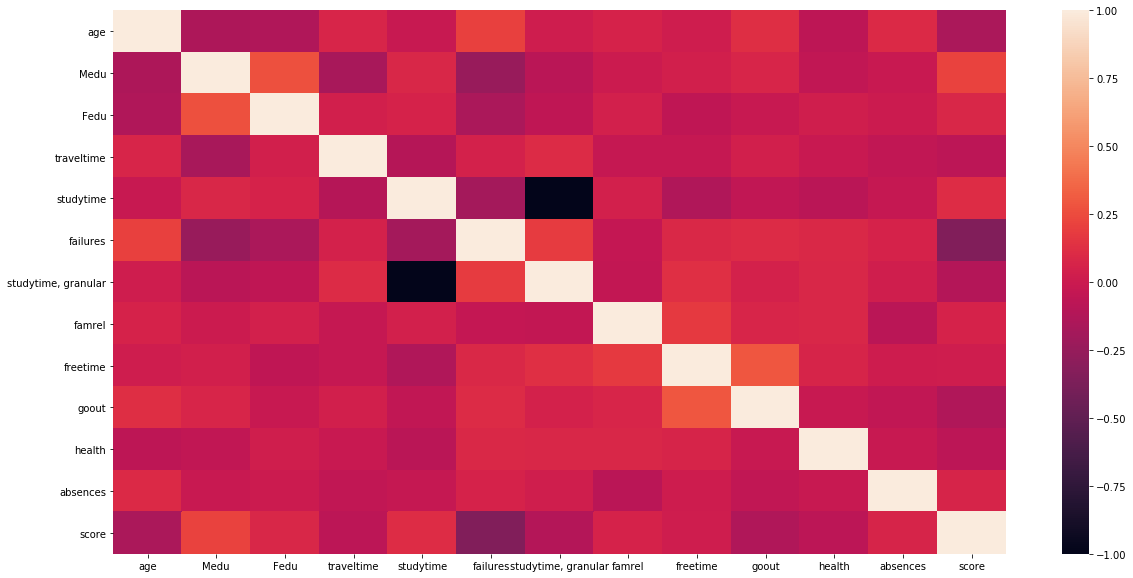

In [5]:
sns.heatmap(data.corr())

Значения в колонках 'studytime' и 'studytime, granular' оказались полностью скоррелированы:

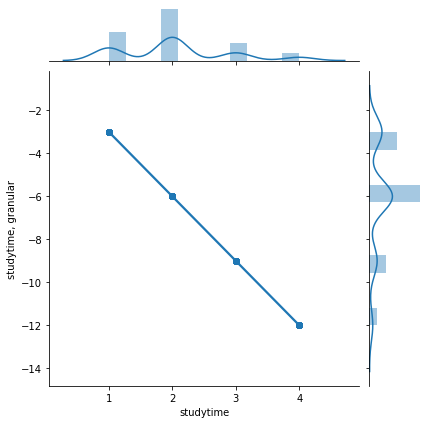

In [6]:
sns.jointplot(x='studytime', y ='studytime, granular', data=data, kind='reg')

Поэтому избавимся от столбца 'studytime, granular':

In [7]:
data = data.drop('studytime, granular', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

Также стоит заметить, что многие переменные, имеющие в датасете тип данных float64, по факту не являются количественными переменными. В этих столбцах переменные могут принимать значения лишь из конечного набора качественно определенных категорий (образование матери - Medu, образование отца - Fedu, время в пути до школы - traveltime, время на учёбу помимо школы - studytime, количество внеучебных неудач - failures, семейные отношения - famrel, свободное время после школы - freetime, проведение времени с друзьями - goout, текущее состояние здоровья - health). Чтобы в дальнейшем не было путаницы, приведем тип этих переменных к типу object, и будем работать с ними дальше как с номинативными переменными:

In [8]:
data['Medu']=data.Medu.astype('object')
data['Fedu']=data.Fedu.astype('object')
data['traveltime']=data.traveltime.astype('object')
data['studytime']=data['studytime'].astype('object')
data['failures']=data.failures.astype('object')
data['famrel']=data.famrel.astype('object')
data['freetime']=data.freetime.astype('object')
data['goout']=data.goout.astype('object')
data['health']=data.health.astype('object')

In [9]:
# проверим тип данных снова
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    object 
 7   Fedu        365 non-null    object 
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    object 
 13  studytime   382 non-null    object 
 14  failures    367 non-null    object 
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

## Анализ распределения признака для числовых переменных, устранение выбросов для числовых переменных.

Воспользуемся формулой межквартильного размаха, чтобы определять выбросы точно. Напишем функцию, которая будет определять есть ли в значениях данного столбца выбросы:

In [10]:
def iqr(data,column):
    data = data.dropna(subset=[column]) #удалим пропущенные значения в данной колонке
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
   # print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
   #   , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    if (data[column].max() > (perc75 + 1.5*IQR)) | (data[column].min() < (perc25 - 1.5*IQR)):
        print('В столбце {} есть выбросы'.format(column))
        print("Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
        display(data[column].describe())
        sns.countplot(x = column, data = data)
        plt.show()

Определим список названий столбцов, в которых типы объектов являются числовыми (int64 или float64):

In [11]:
data_numeric_columns = data.select_dtypes(include=['int64','float64']).columns
display(data_numeric_columns)

Index(['age', 'absences', 'score'], dtype='object')

Теперь посмотрим, в каких из этих столбцов есть выбросы:

В столбце age есть выбросы
Границы выбросов: [13.0, 21.0].


count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

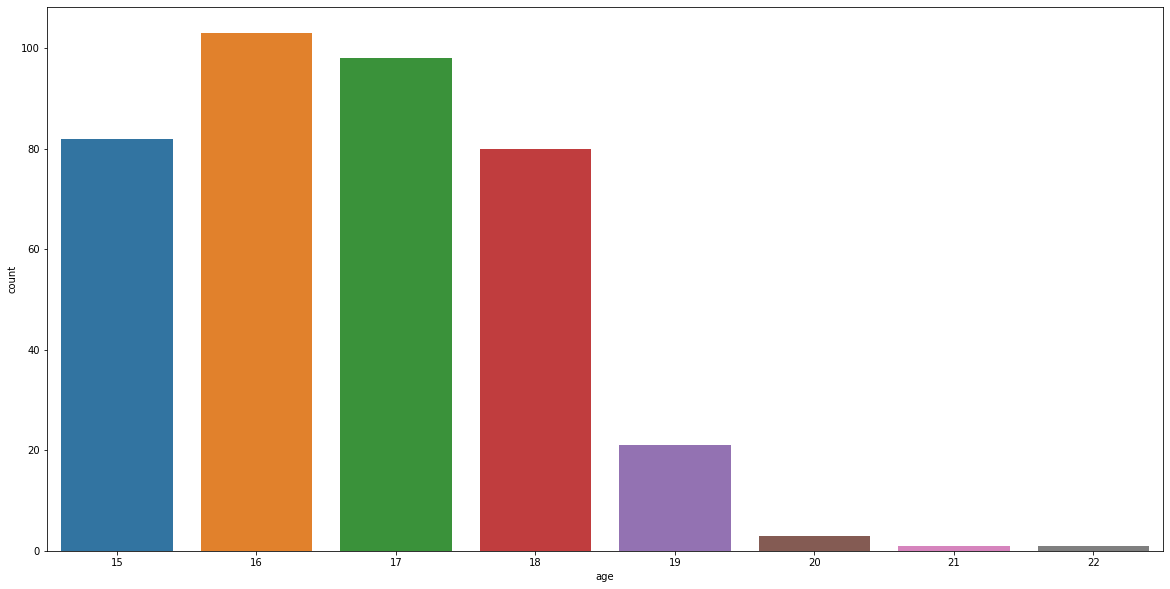

В столбце absences есть выбросы
Границы выбросов: [-12.0, 20.0].


count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

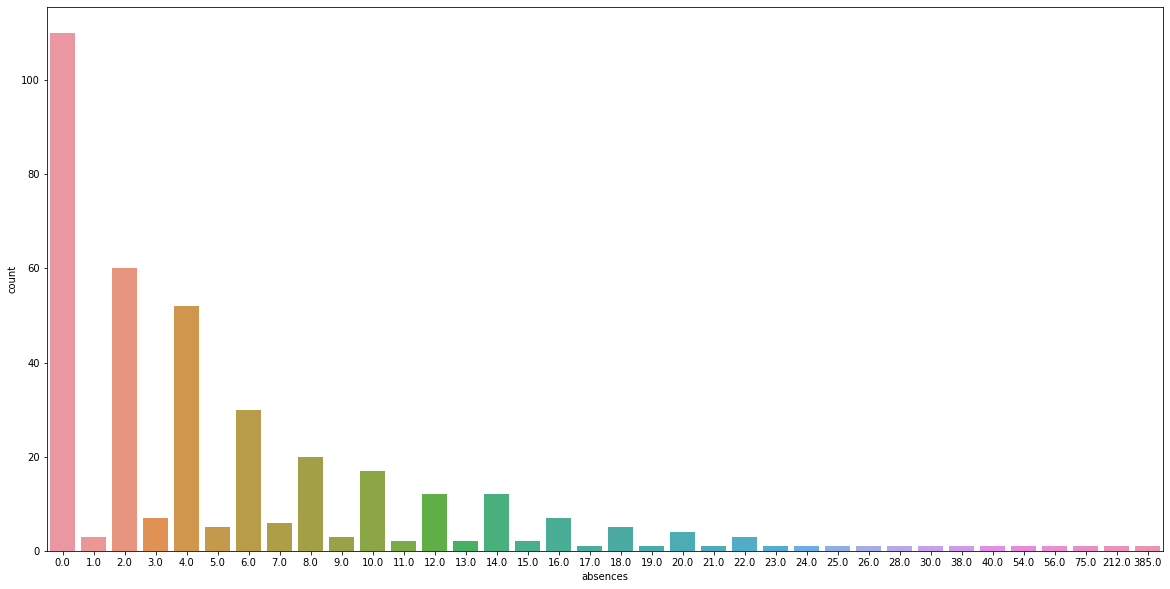

In [12]:
for col in data_numeric_columns:
    iqr(data,col)

Для возраста значение 22 года оказалось вне границ выбросов, и значение 21 оказалось на верхней границе выбросов, поэтому исключим данные с такими значениями из датасета:

In [13]:
data = data.loc[data.age<21]

Для количества пропущенный занятий (absences) верхняя граница выбросов оказалась равна 20, но при этом остается много значений, которые выходят за эту границу. Изучим данные об учащихся, которые пропустили более 20 занятий:

In [14]:
data[data['absences']>20].sort_values(by='absences')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
260,GP,F,18,U,GT3,NaN,4,3,NaN,other,home,father,1,2,0,no,yes,yes,no,yes,yes,yes,yes,3,1,2,2,21.0,90.0
313,GP,F,19,U,NaN,NaN,3,2,services,other,reputation,other,2,2,NaN,no,NaN,NaN,no,no,yes,yes,yes,4,2,2,1,22.0,55.0
277,GP,M,18,U,GT3,T,4,4,NaN,services,home,mother,2,1,0,no,no,yes,yes,yes,yes,yes,no,3,2,4,3,22.0,45.0
216,GP,F,17,U,GT3,T,4,3,other,NaN,reputation,mother,1,2,2,no,no,yes,no,yes,yes,yes,yes,3,4,5,1,22.0,20.0
320,GP,F,17,U,GT3,A,4,3,services,services,course,mother,1,2,NaN,no,yes,yes,no,yes,NaN,yes,yes,5,2,2,5,23.0,65.0
198,GP,F,17,U,GT3,NaN,4,4,services,teacher,home,mother,2,1,1,no,yes,no,no,yes,yes,NaN,no,4,2,4,2,24.0,90.0
40,GP,F,16,U,LE3,T,2,2,other,other,home,mother,2,2,1,no,NaN,no,yes,no,yes,yes,yes,3,3,3,3,25.0,55.0
103,GP,F,15,U,GT3,T,3,2,services,other,home,mother,2,2,0,yes,yes,yes,no,yes,yes,yes,no,4,3,5,2,26.0,30.0
205,GP,F,17,U,GT3,T,3,4,at_home,services,home,mother,1,3,1,no,yes,yes,no,yes,yes,yes,yes,4,4,3,5,28.0,45.0
280,GP,M,17,U,NaN,A,4,NaN,services,other,home,mother,2,1,NaN,no,no,yes,yes,yes,yes,yes,NaN,4,NaN,4,5,30.0,40.0


In [15]:
data = data.loc[data.absences<=30]

Score — важный столбец, так как нужно исследовать влияние всех остальных переменных на этот показатель. Изучим данные в этом столбце и посмотрим распределение баллов, которые получали учащиеся на экзамене по математике:

count    369.000000
mean      52.113821
std       22.966257
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

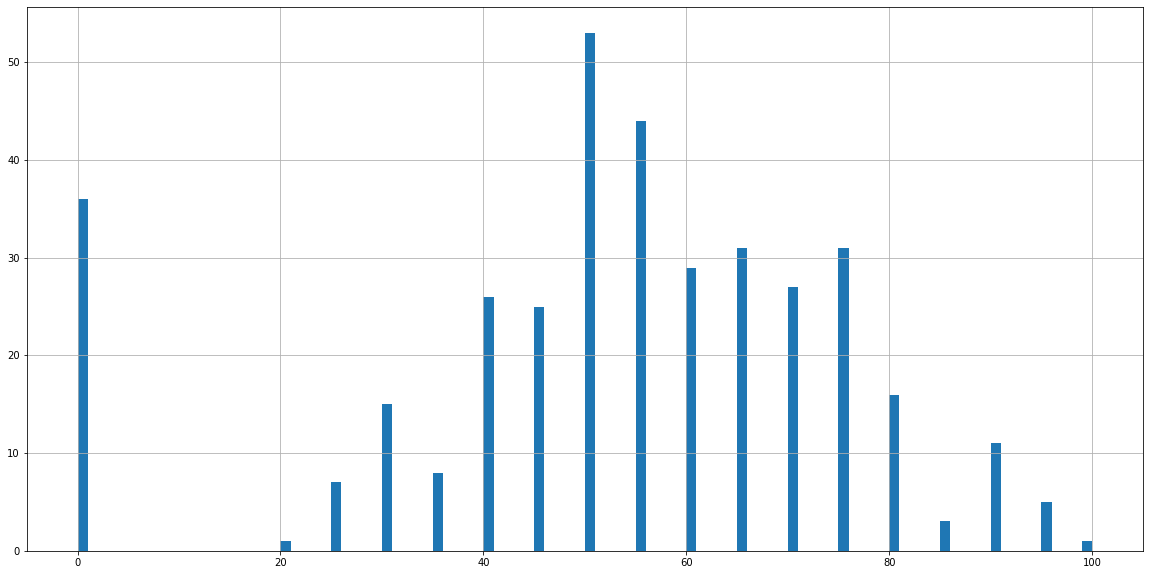

In [16]:
data.score.hist(bins=100)
data.score.describe()

Гистограмма показывает что, часть учащихся почему-то получили 0 баллов. Здравый смысл подсказывает, что либо данные по этим учащися были пропущены, либо они и вовсе не писали экзамен (могли на него не явиться). Потому что следующее минимальное значение уже выше 20. Поэтому исключим из датасета все строки, где значение score равно 0:

In [17]:
data = data.query('score > 0')

## Корреляционный анализ количественных переменных. Отбор не коррелирующих переменных

Построим графики зависимости количественных переменных друг от друга:

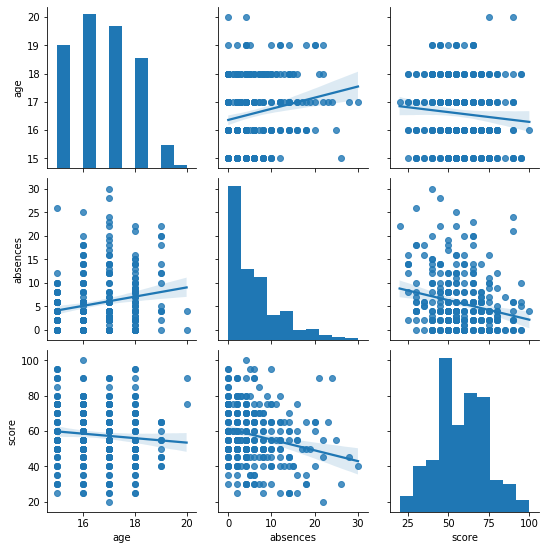

In [18]:
sns.pairplot(data, vars=['age', 'absences', 'score'], kind = 'reg')

Используем для наглядности матрицу корреляции:

In [19]:
data.corr()

,age,absences,score
age,1.000000,0.196694,-0.093854
absences,0.196694,1.000000,-0.224750
score,-0.093854,-0.224750,1.000000


Переменные age и score слабоскореллированы, как и absences и score. Отрицательная корреляция между возрастом и результатами учащихся может говорить о том, что с увеличением возраста результаты учеников ухудшаются. Также отрицательная корреляция между число пропущенных занятий и результатом может говорить о том, что чем больше занятий пропустил учащийся, тем хуже результат.

## Оценка количества уникальных значений для номинативных переменнных

Сначала определим список названий переменных, которые являются номинативными переменными в нашем датасете. Это те колонки, в которых тип данных object:

In [20]:
data_nominative_columns = data.select_dtypes(include=['object']).columns
display(data_nominative_columns)

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health'],
      dtype='object')

Напишем функцию, которая для каждого столбца заменит пропущенные значения и значения 'nan' на None, посчитает количество уникальных значений переменных, а также выведет сколько значений встречалось более n раз:

In [21]:
def nominative_unique_freq(data,column,n):
    data = data.dropna(subset=[column]) #удалим пропущенные значения в данной колонке
    data[column] = data[column].astype(str).apply(lambda x: None if x.strip() == '' else x)
    data[column] = data[column].apply(lambda x: None if x == 'nan' else x )
    print('Количество уникальных значений в столбце {} равно {}'.format(column,len(data[column].unique())))
    print(data[column].unique())
    sns.countplot(x = column, data = data)
    plt.show()
    print('Количество значений, встречающихся более {} раз: {}'.format(n,(data[column].value_counts()>=n).sum()))
    print('\n')

Количество уникальных значений в столбце school равно 2
['GP' 'MS']


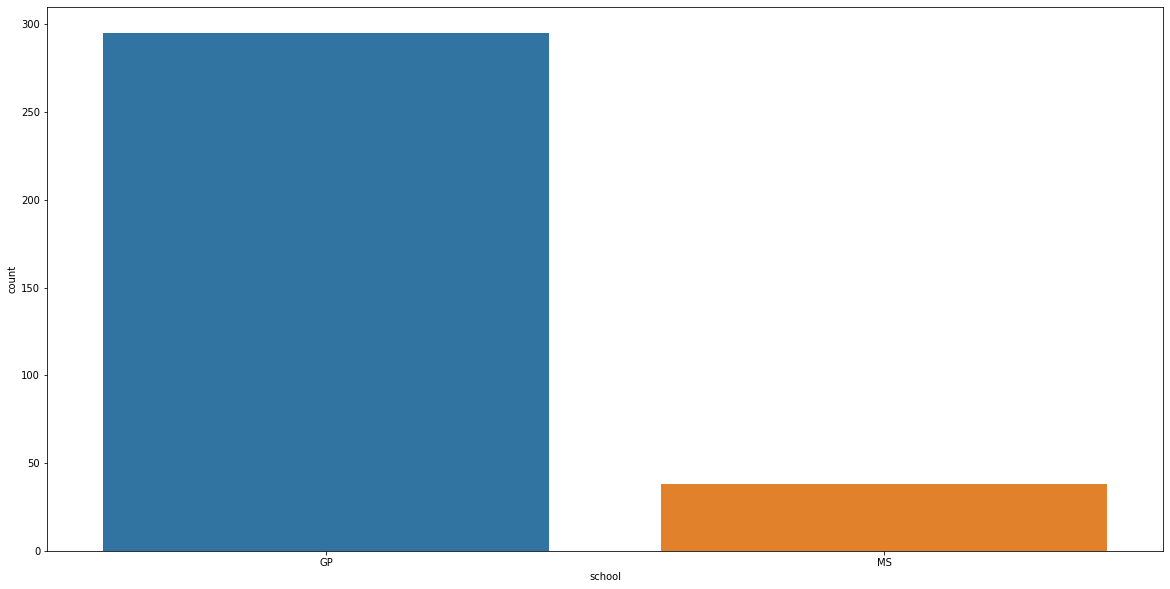

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце sex равно 2
['F' 'M']


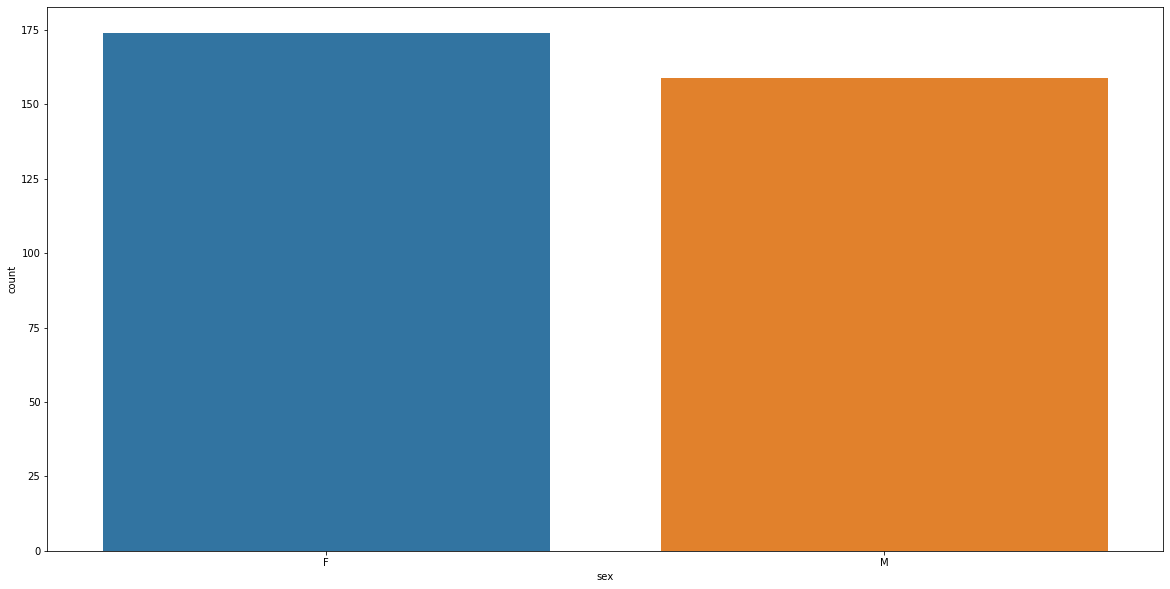

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце address равно 2
['U' 'R']


C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


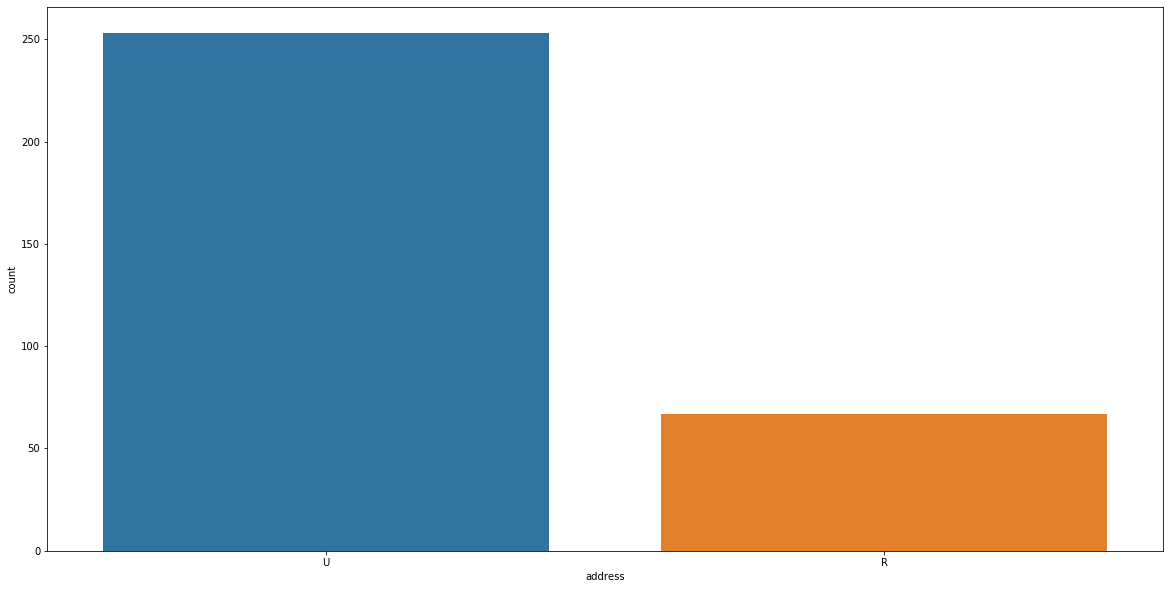

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце famsize равно 2
['GT3' 'LE3']


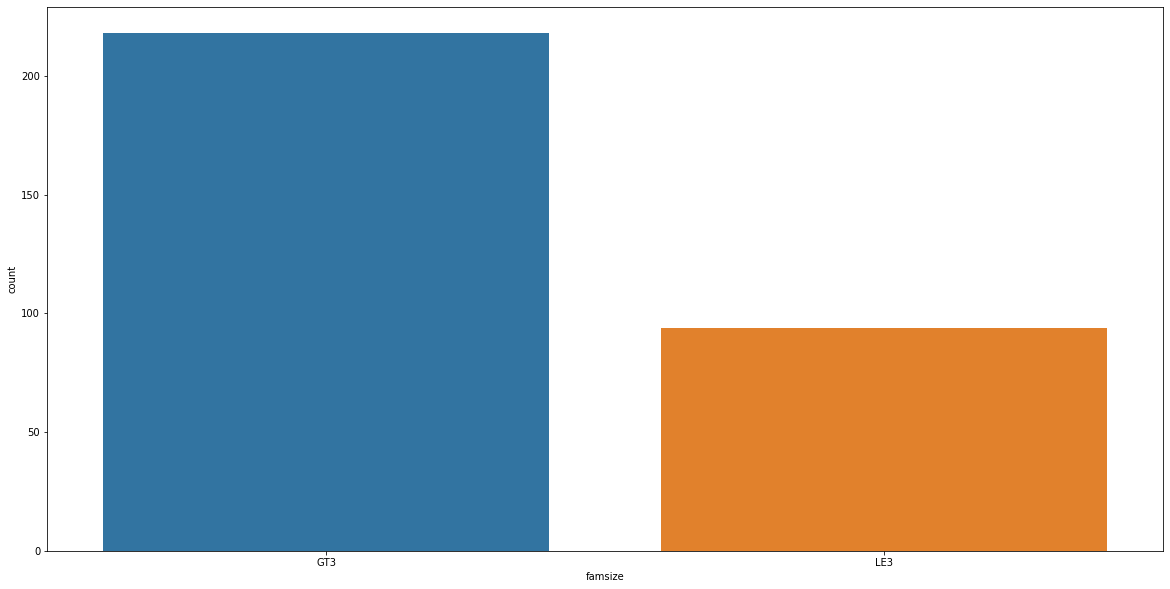

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце Pstatus равно 2
['A' 'T']


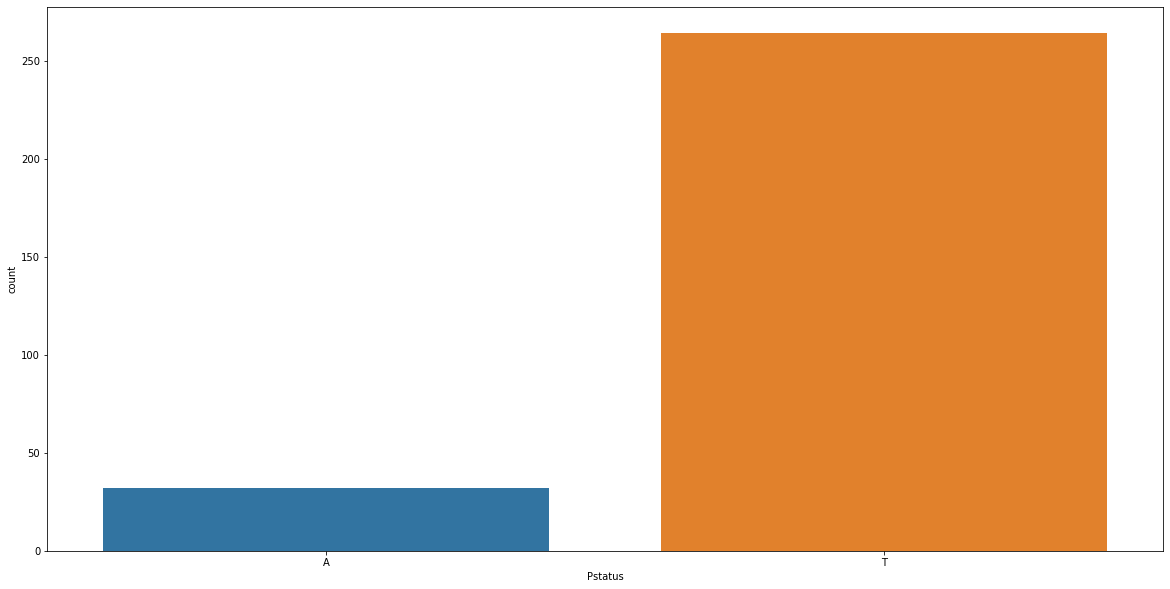

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце Medu равно 5
['4.0' '1.0' '3.0' '2.0' '0.0']


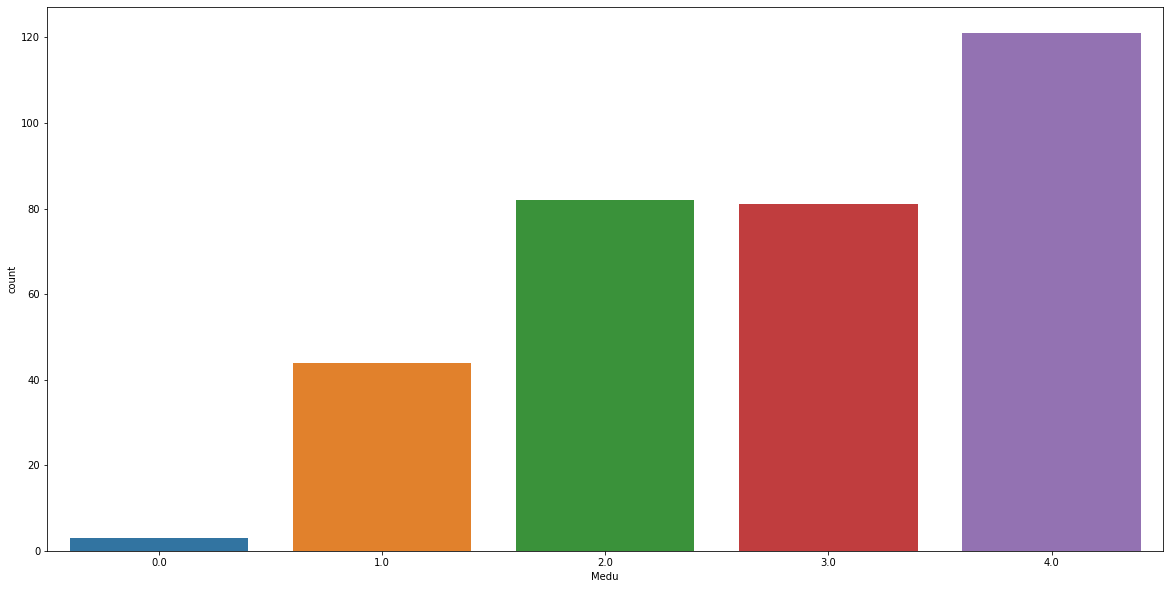

Количество значений, встречающихся более 30 раз: 4


Количество уникальных значений в столбце Fedu равно 6
['4.0' '1.0' '2.0' '3.0' '40.0' '0.0']


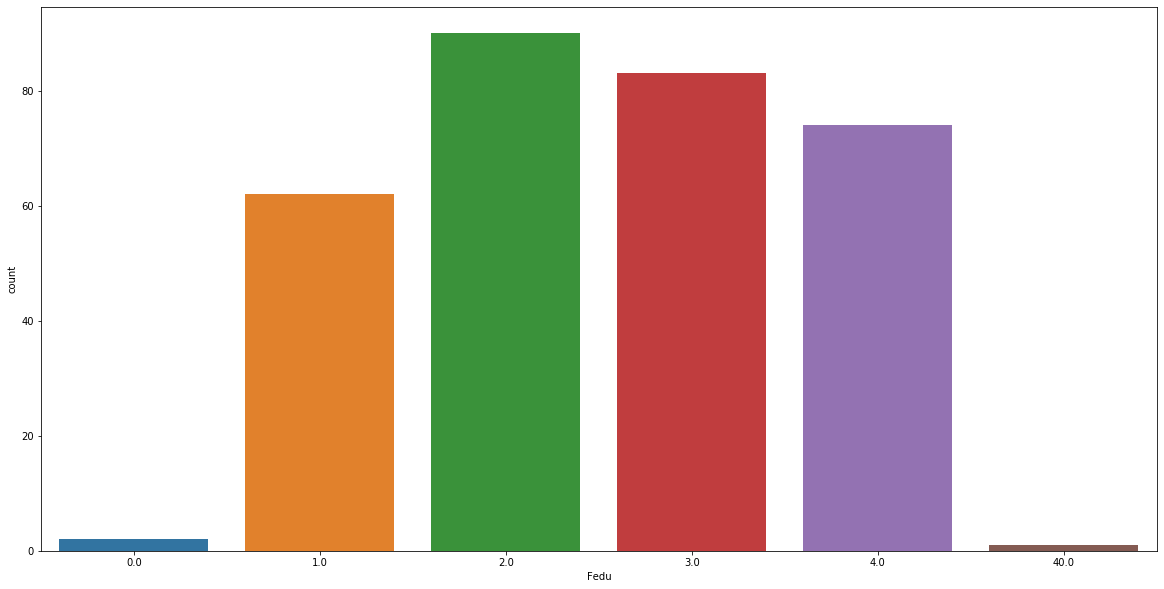

Количество значений, встречающихся более 30 раз: 4


Количество уникальных значений в столбце Mjob равно 5
['at_home' 'health' 'other' 'services' 'teacher']


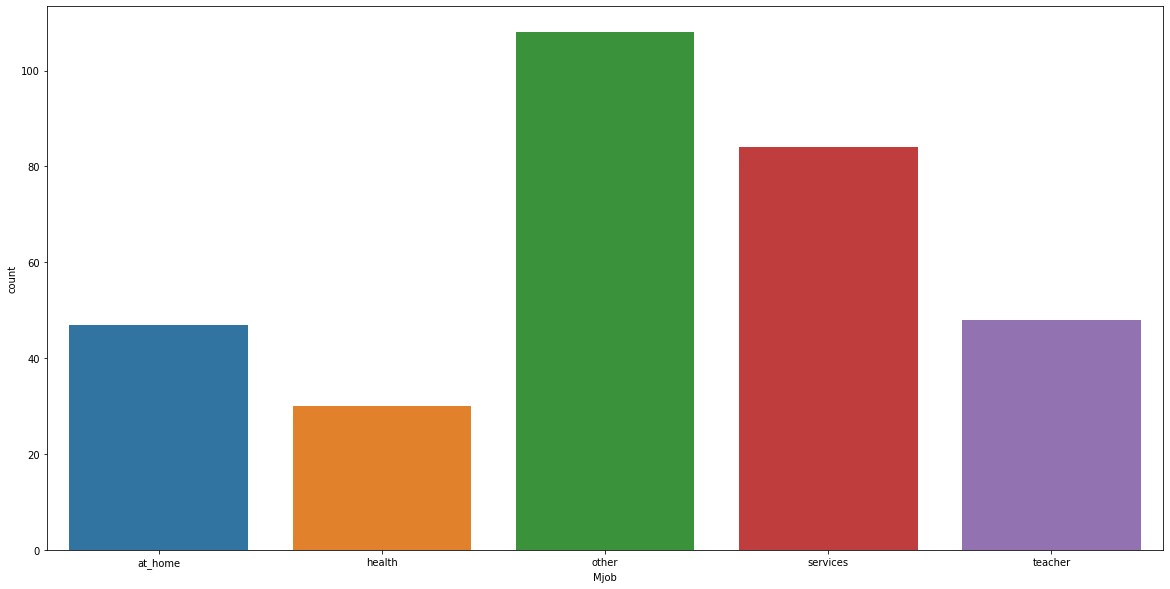

Количество значений, встречающихся более 30 раз: 5


Количество уникальных значений в столбце Fjob равно 5
['teacher' 'other' 'health' 'services' 'at_home']


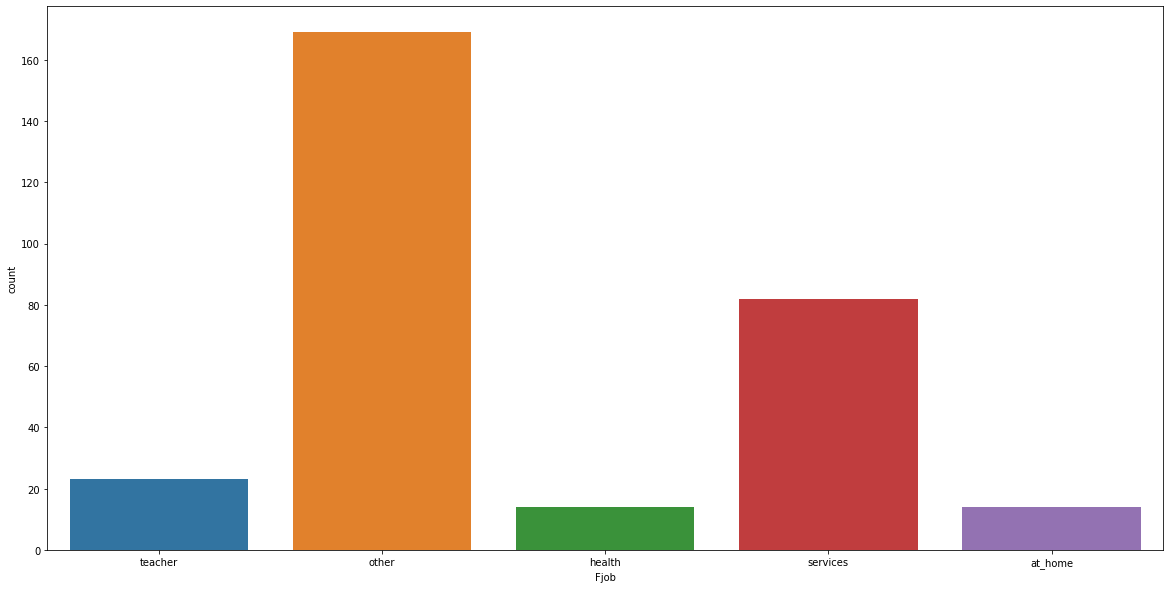

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце reason равно 4
['course' 'other' 'home' 'reputation']


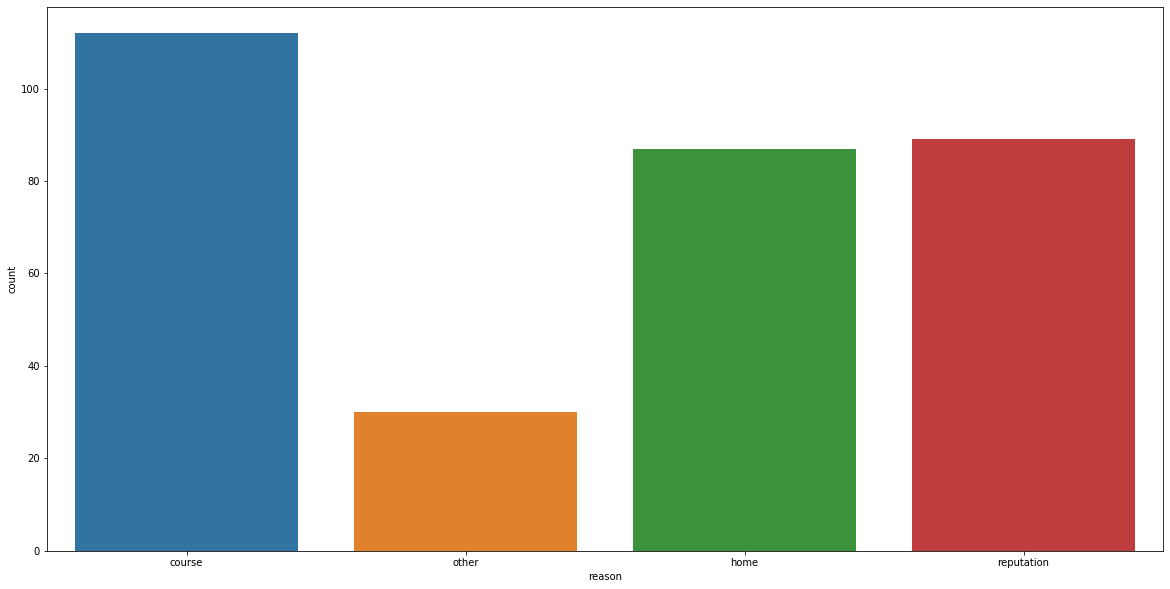

Количество значений, встречающихся более 30 раз: 4


Количество уникальных значений в столбце guardian равно 3
['mother' 'father' 'other']


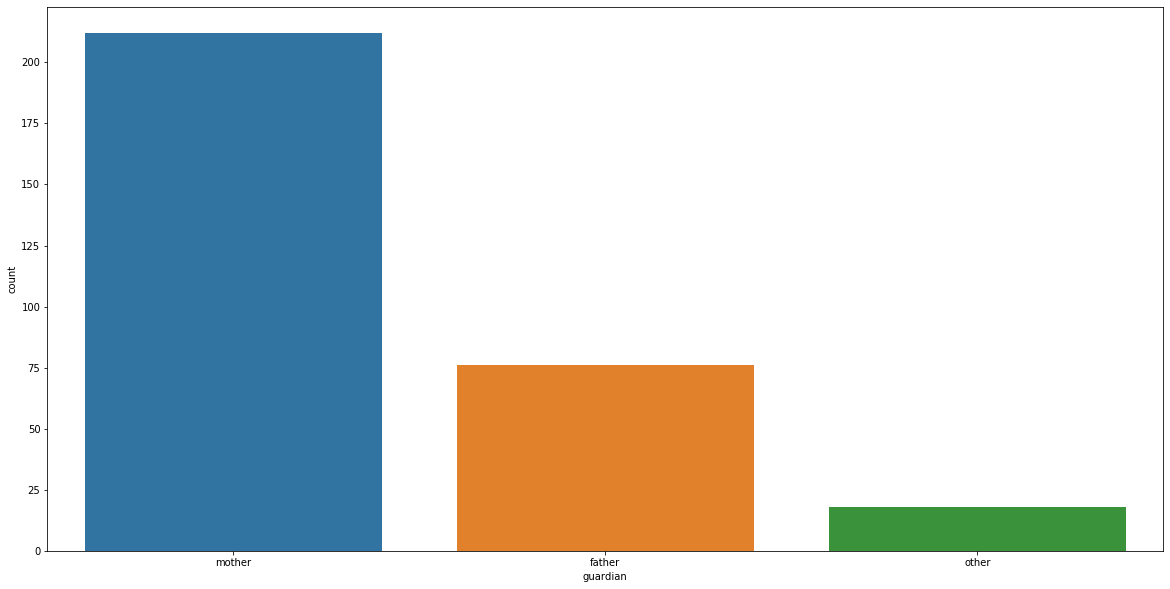

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце traveltime равно 4
['2.0' '1.0' '3.0' '4.0']


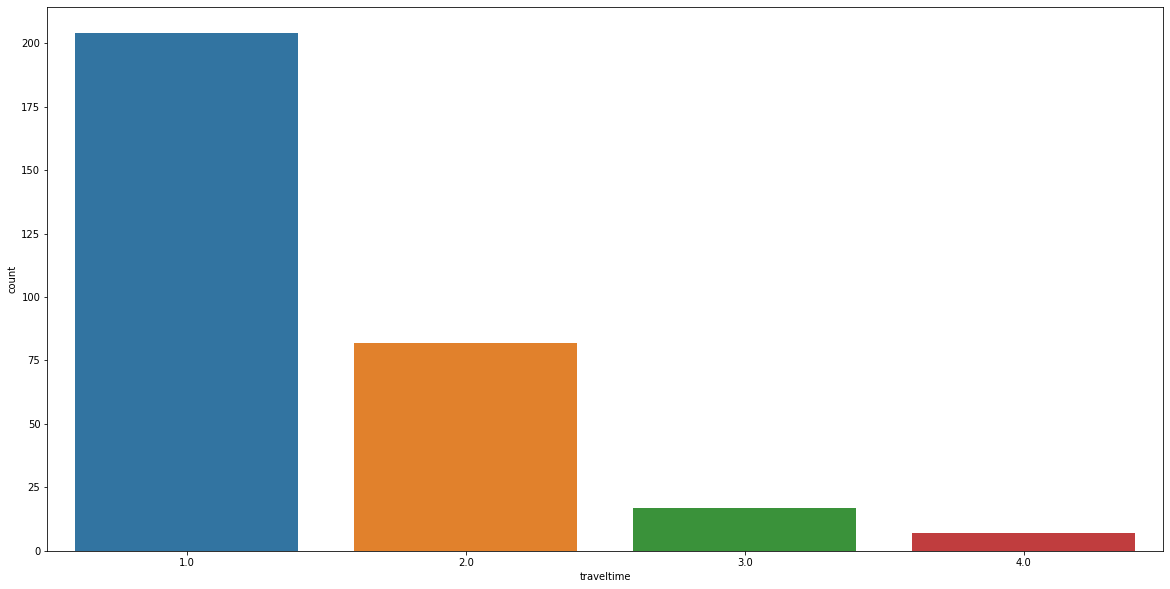

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце studytime равно 4
['2.0' '3.0' '1.0' '4.0']


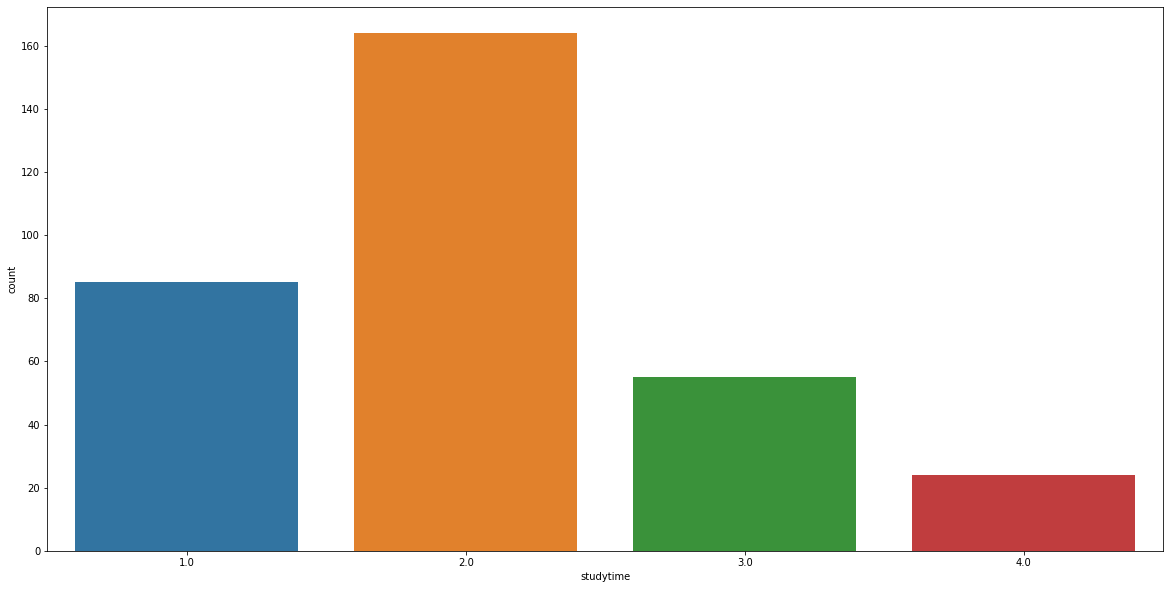

Количество значений, встречающихся более 30 раз: 3


Количество уникальных значений в столбце failures равно 4
['0.0' '3.0' '2.0' '1.0']


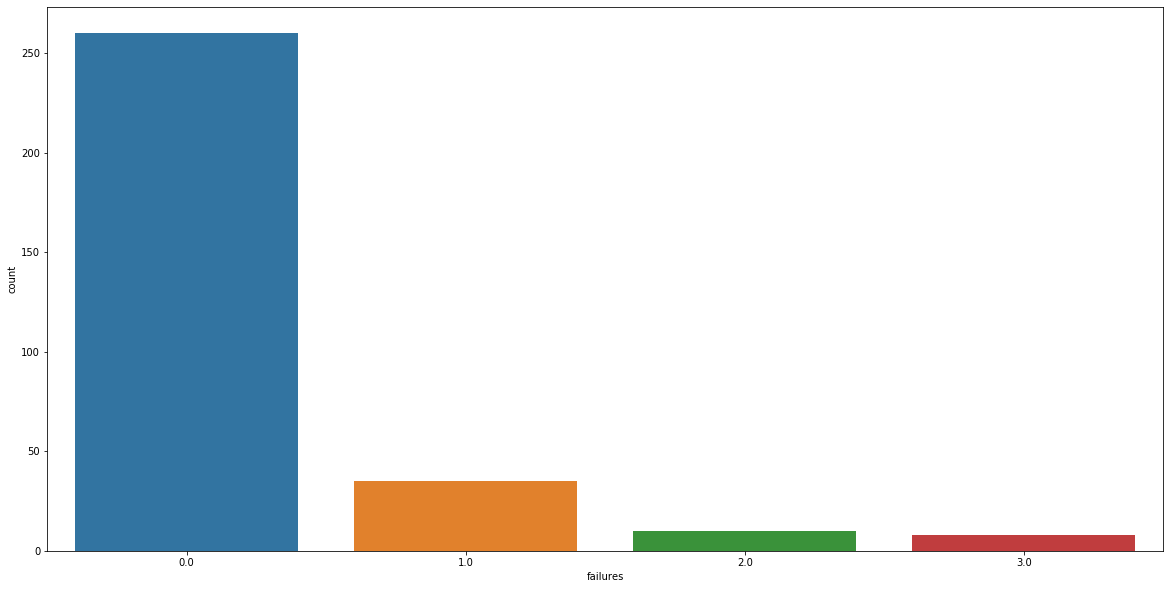

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце schoolsup равно 2
['yes' 'no']


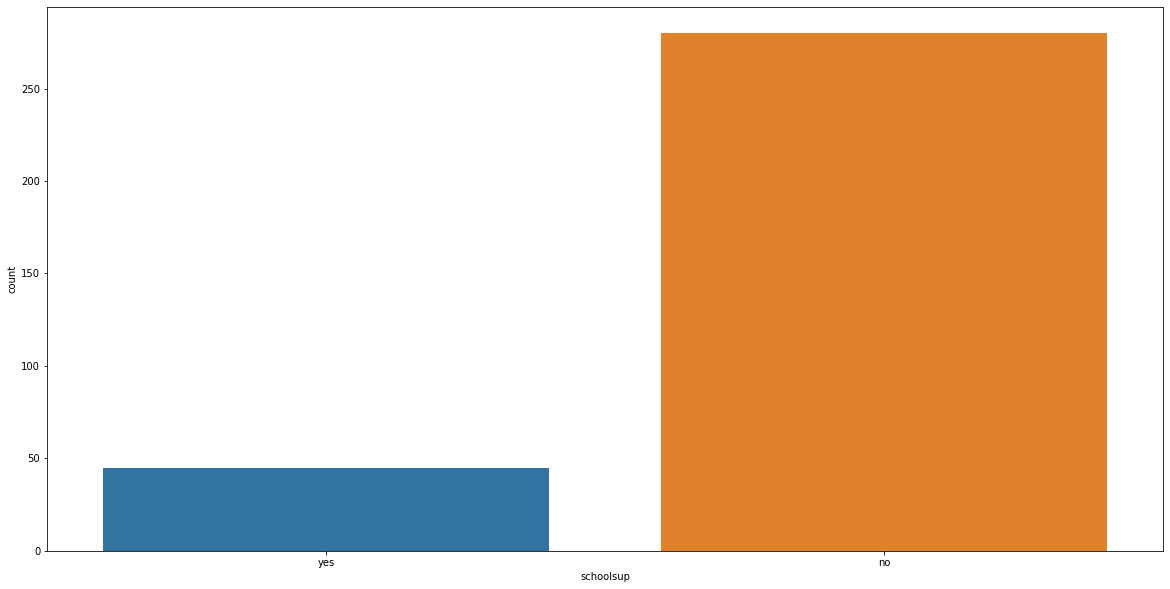

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце famsup равно 2
['no' 'yes']


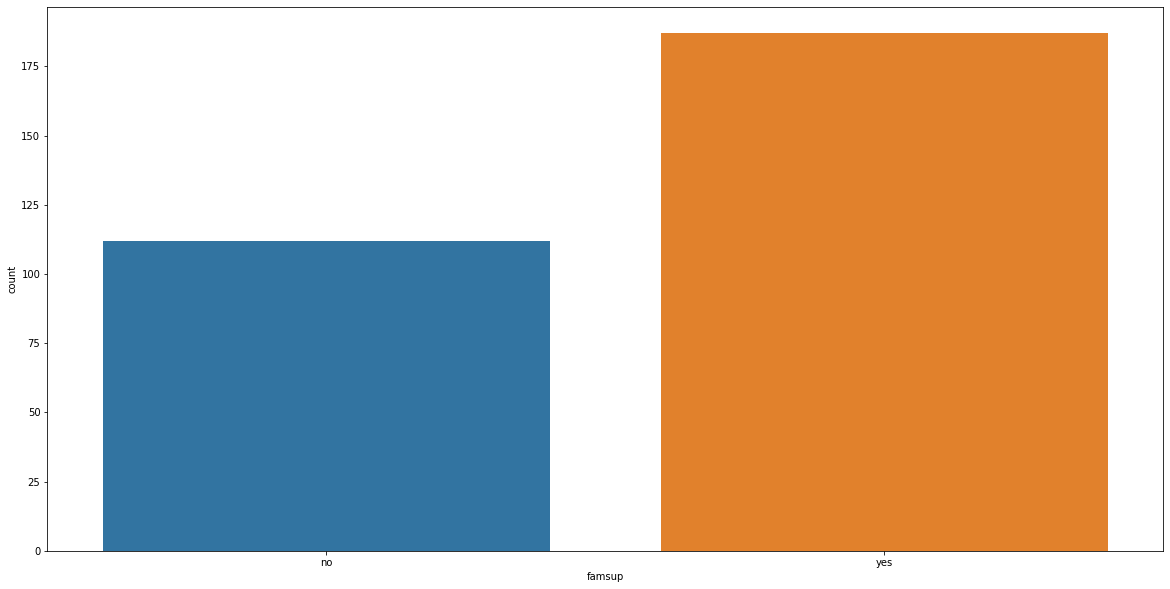

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце paid равно 2
['no' 'yes']


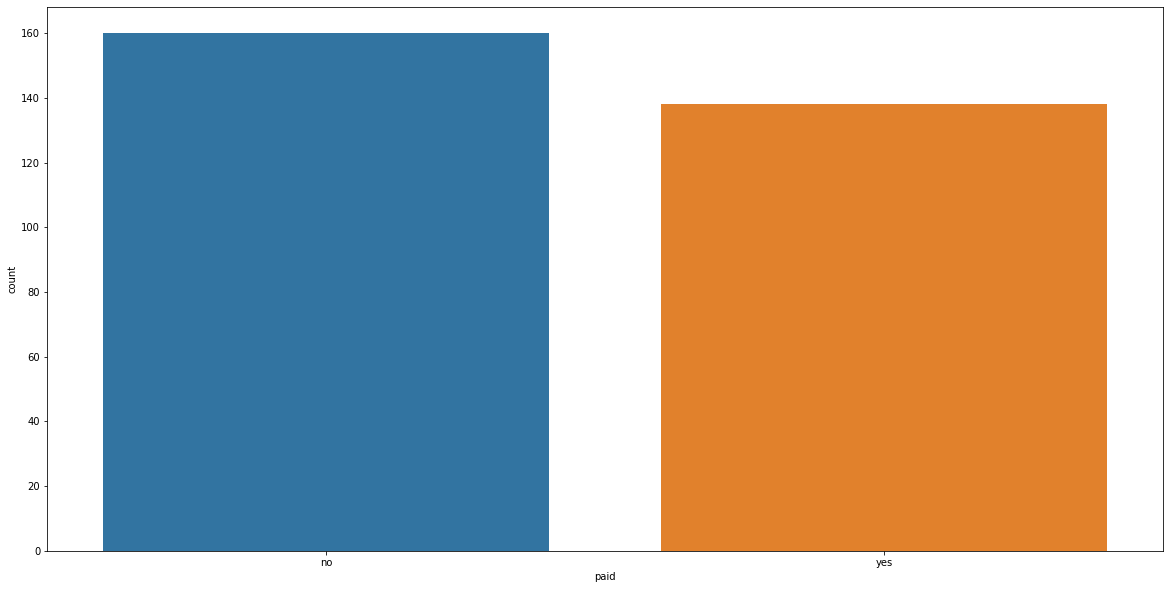

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце activities равно 2
['no' 'yes']


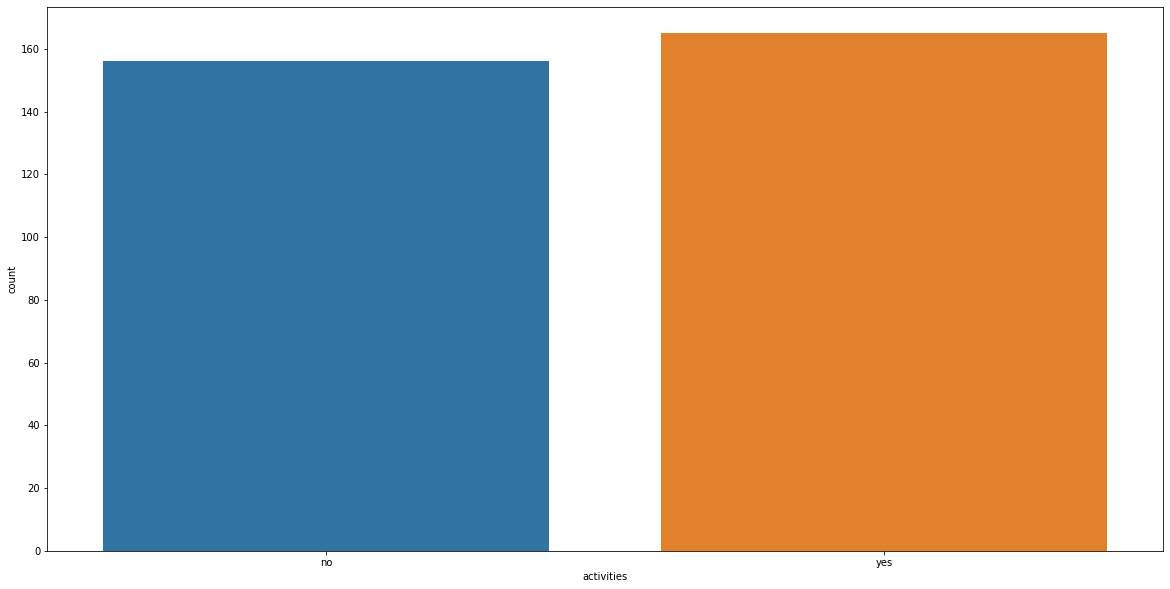

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце nursery равно 2
['yes' 'no']


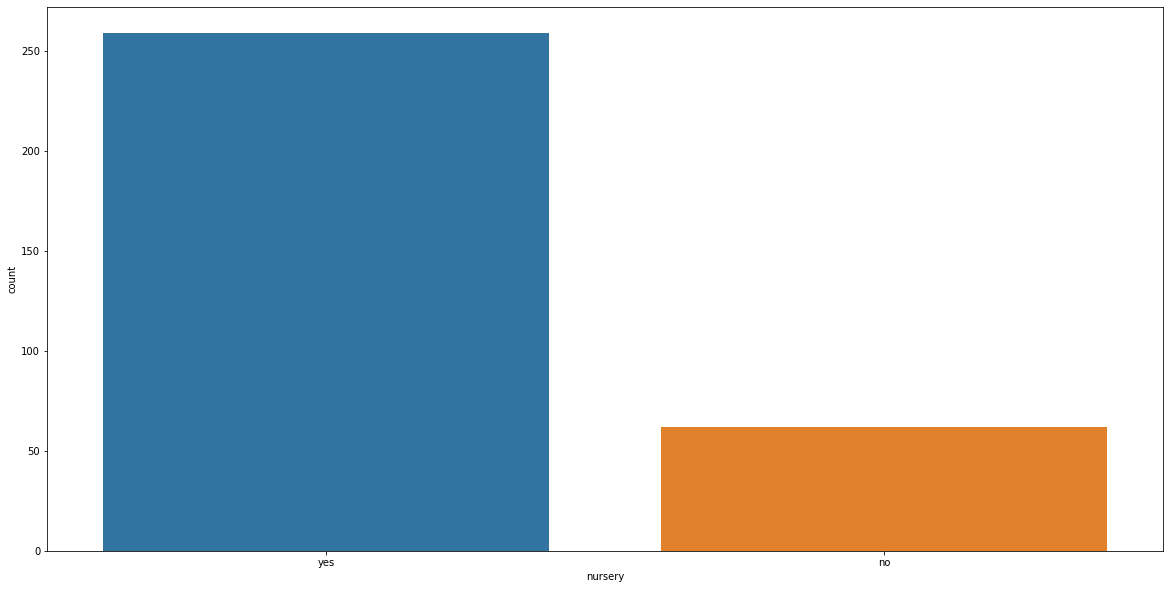

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце higher равно 2
['yes' 'no']


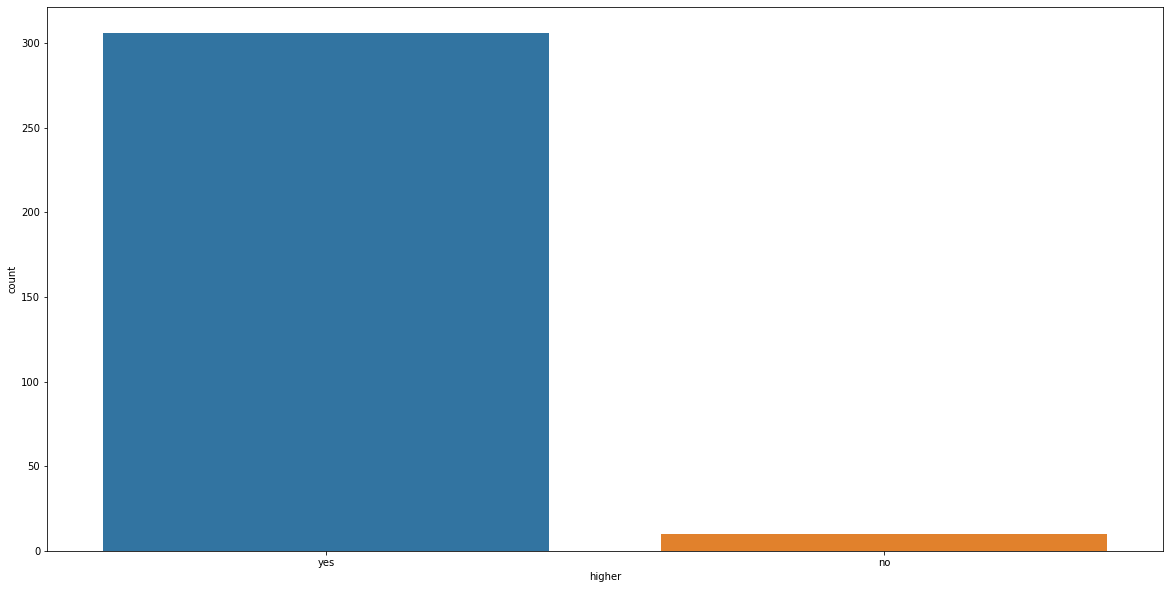

Количество значений, встречающихся более 30 раз: 1


Количество уникальных значений в столбце internet равно 2
['yes' 'no']


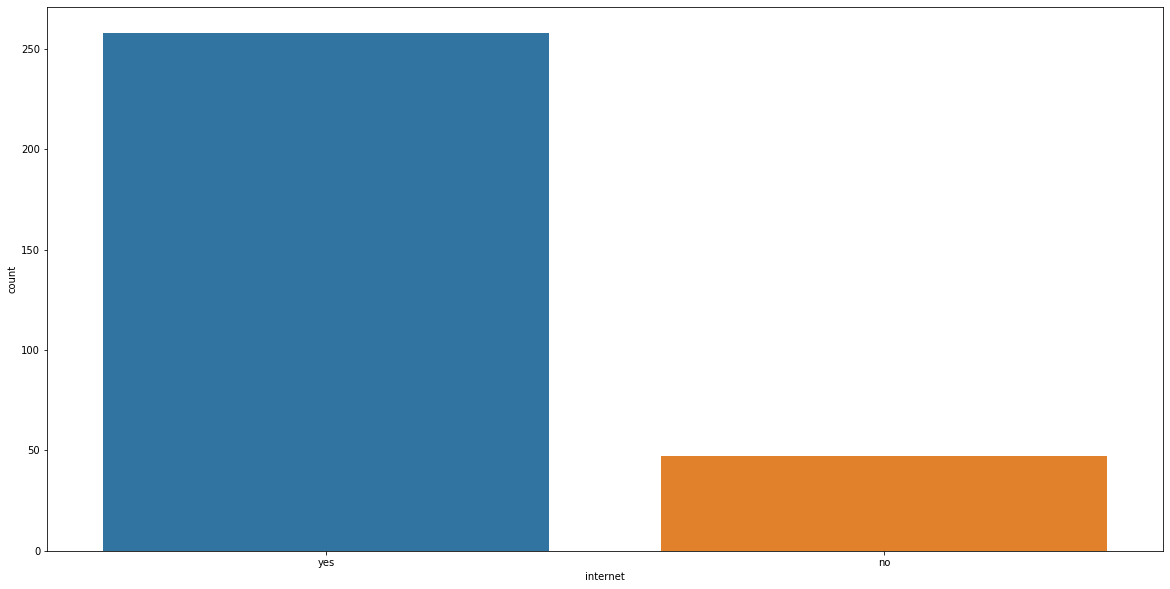

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце romantic равно 2
['no' 'yes']


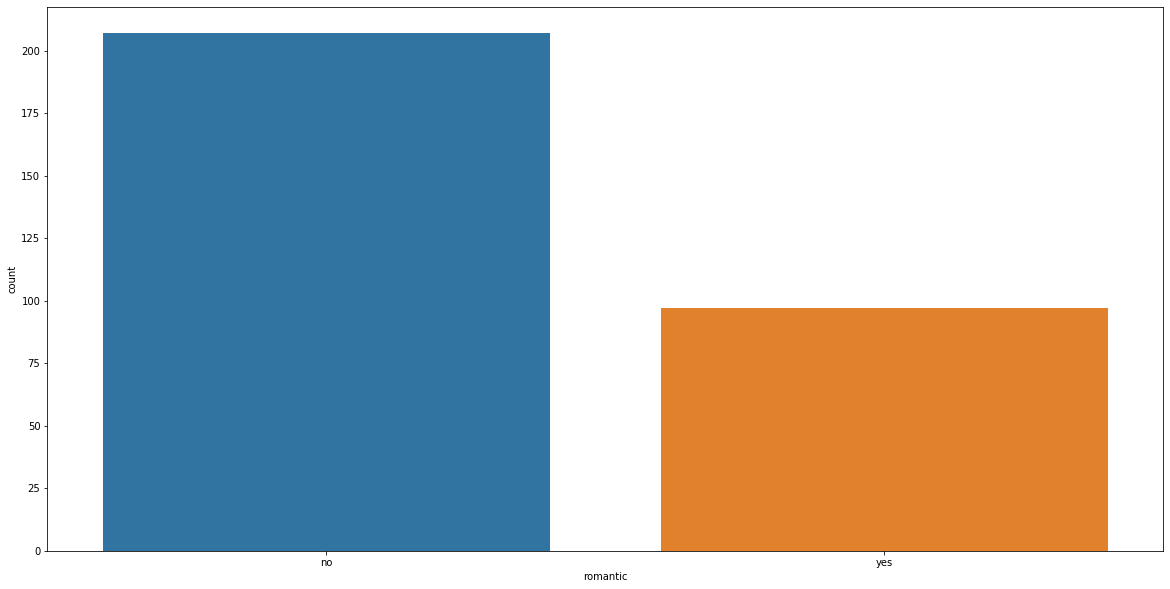

Количество значений, встречающихся более 30 раз: 2


Количество уникальных значений в столбце famrel равно 6
['4.0' '5.0' '3.0' '-1.0' '2.0' '1.0']


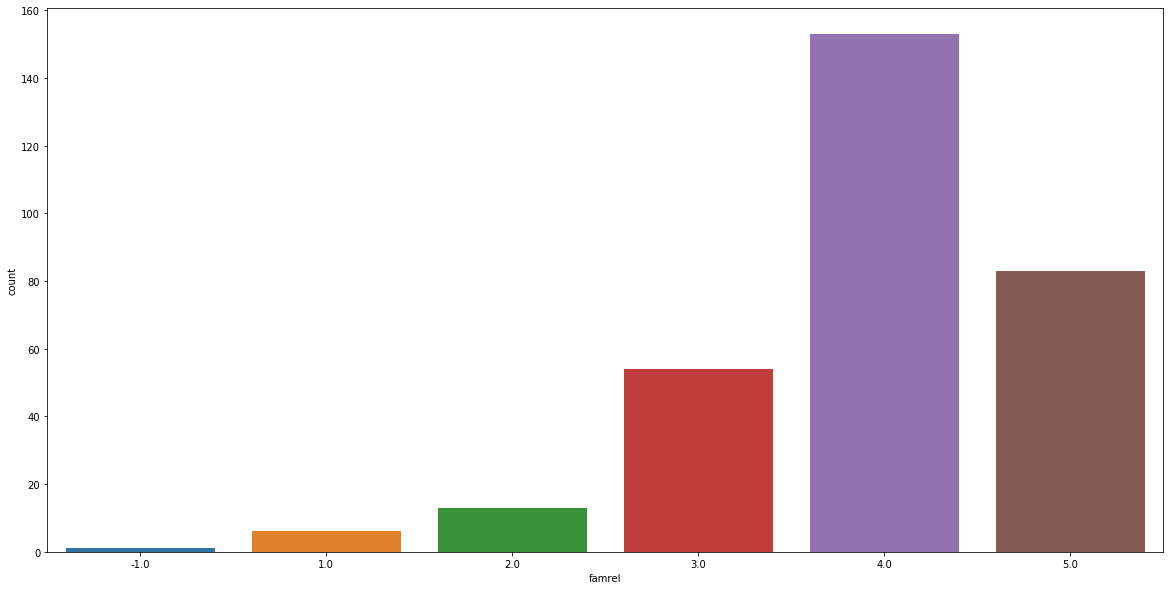

Количество значений, встречающихся более 30 раз: 3


Количество уникальных значений в столбце freetime равно 5
['3.0' '2.0' '4.0' '1.0' '5.0']


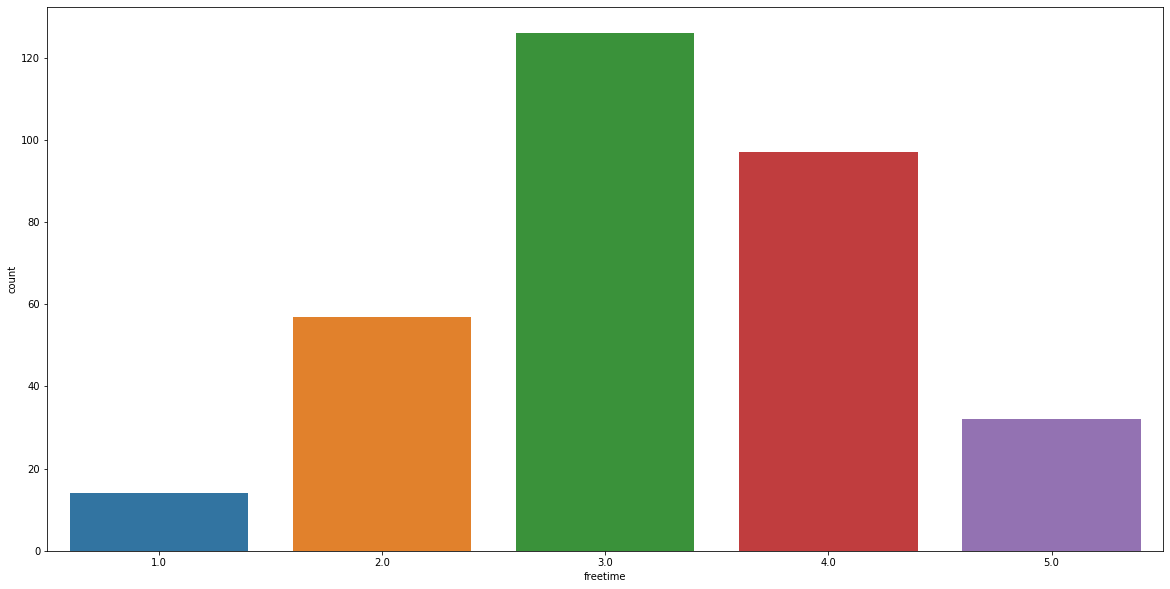

Количество значений, встречающихся более 30 раз: 4


Количество уникальных значений в столбце goout равно 5
['4.0' '3.0' '2.0' '1.0' '5.0']


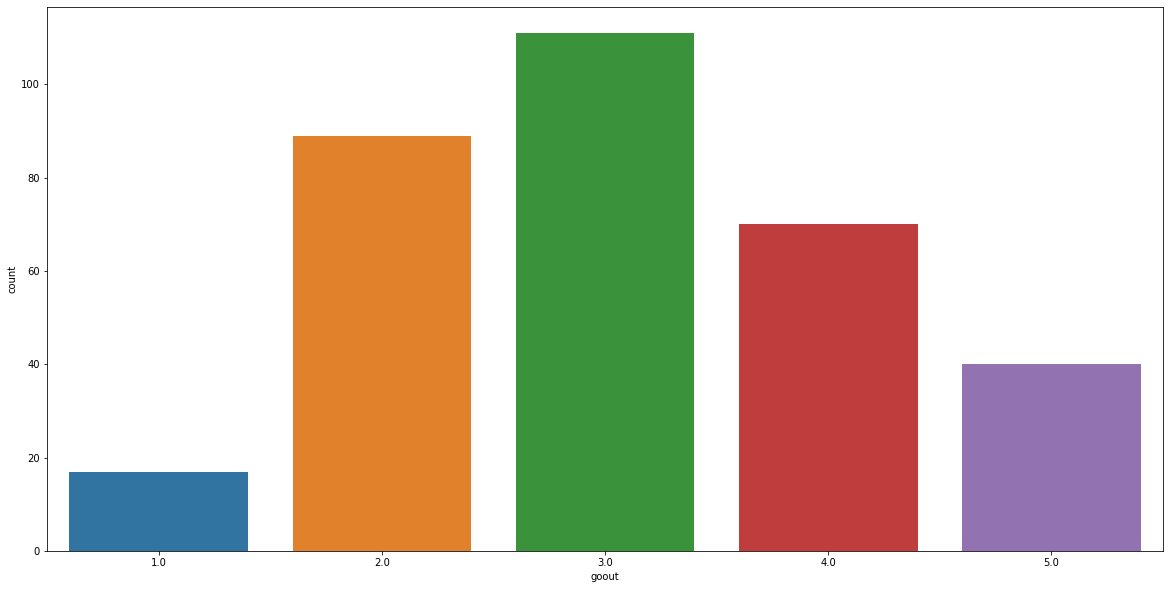

Количество значений, встречающихся более 30 раз: 4


Количество уникальных значений в столбце health равно 5
['3.0' '5.0' '1.0' '2.0' '4.0']


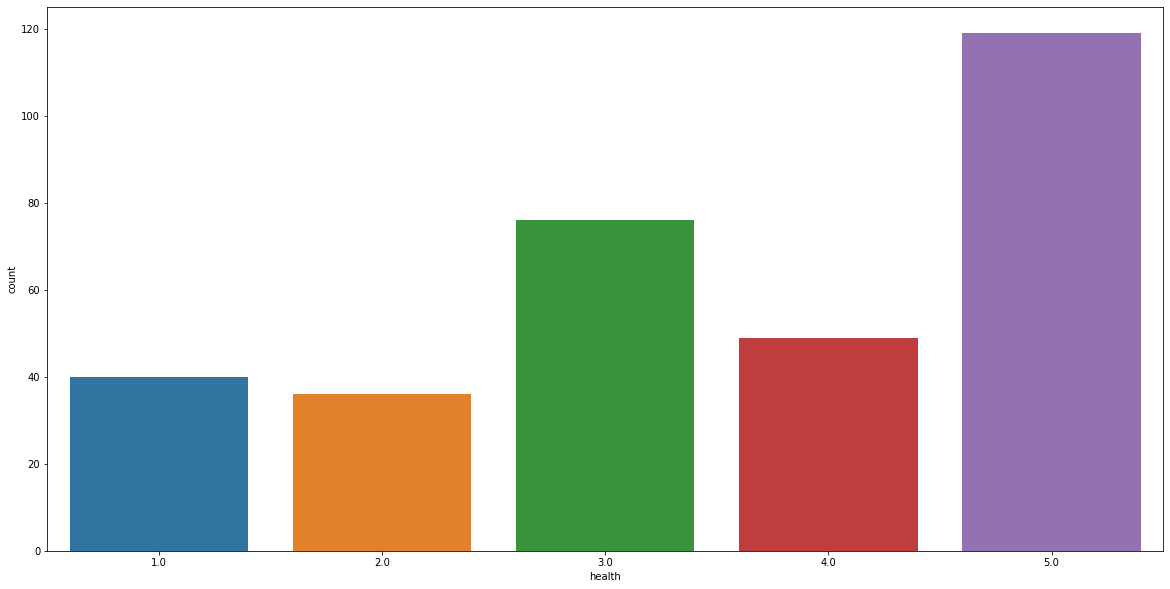

Количество значений, встречающихся более 30 раз: 5




In [22]:
for col in data_nominative_columns:
    nominative_unique_freq(data,col,30)

В столбец Fedu попало ошибочное значение '40.0'  Исключим его:

In [23]:
data = data.query('Fedu != 40.0 ')
data.Fedu.unique()

array([4.0, 1.0, 2.0, 3.0, nan, 0.0], dtype=object)

Аналогично в столбце famrel обнаружилось ошибочное значение '-1.0' Исключим его:

In [24]:
data = data.loc[data['famrel']!=-1.0]
data.famrel.unique()

array([4.0, 5.0, 3.0, nan, 2.0, 1.0], dtype=object)

Напишем функцию, которая будет строить boxplot для номитативной переменной, чтобы посмотреть, различаются ли распределения результатов за экзамен в зависимости от значения этих переменных:

In [25]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data=data)
    ax.set_title('Boxplot for ' + column)
    plt.show()

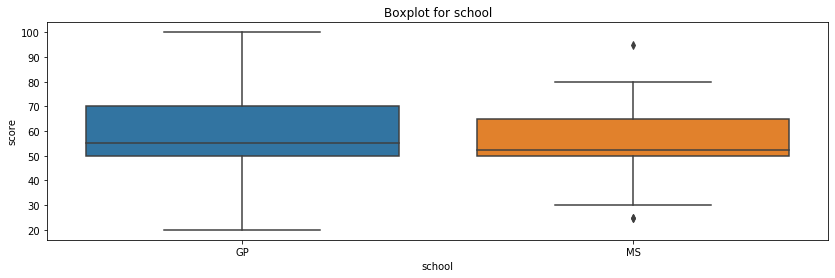

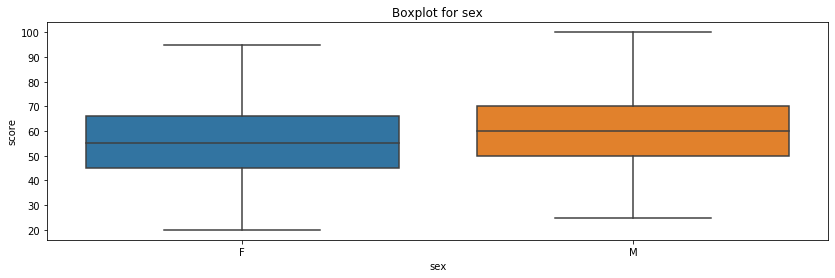

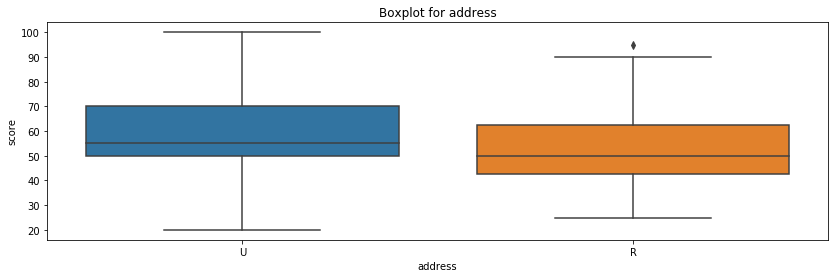

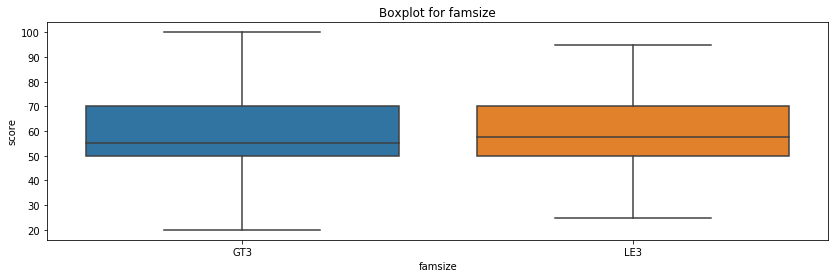

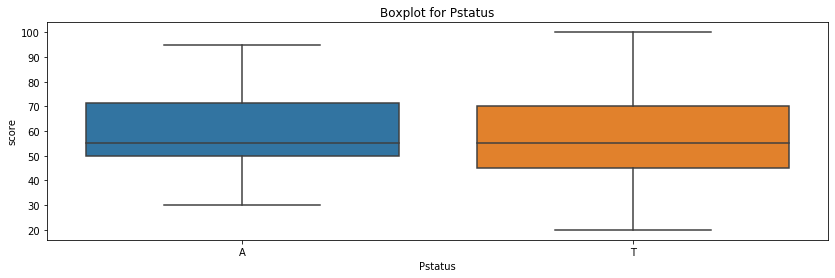

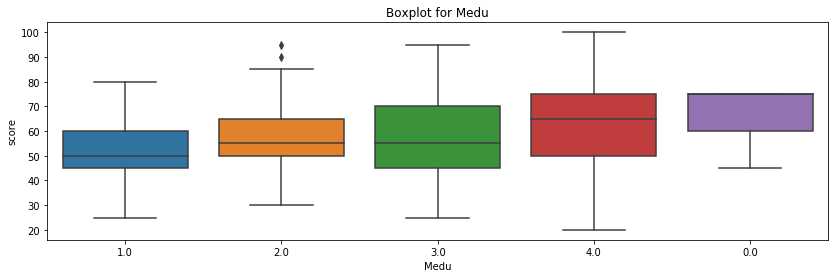

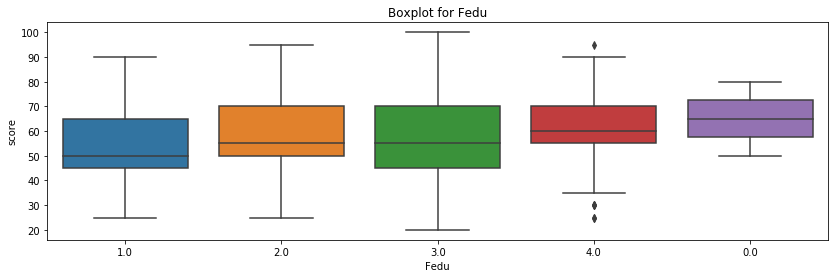

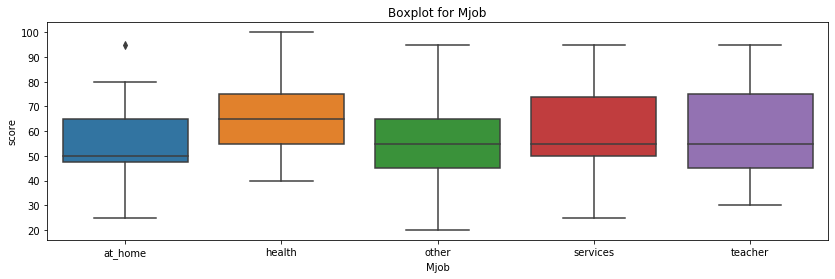

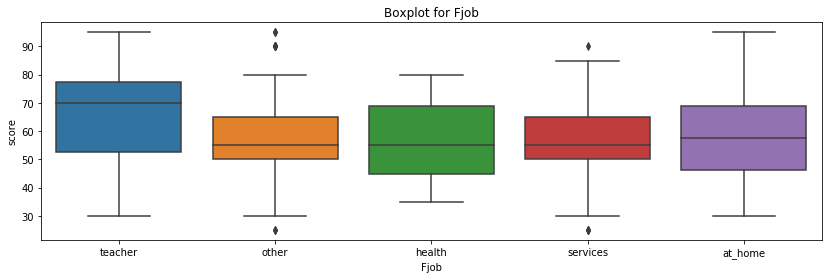

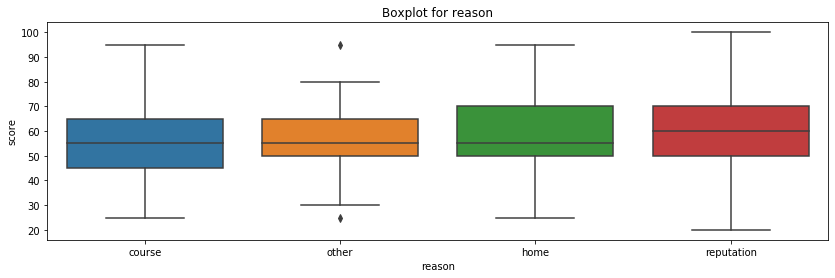

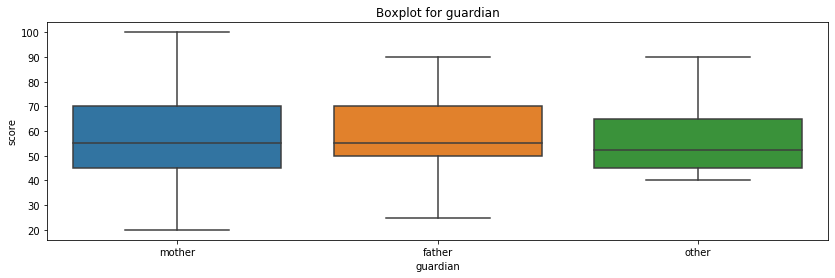

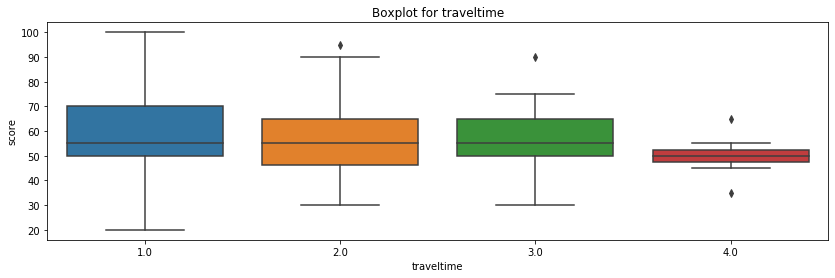

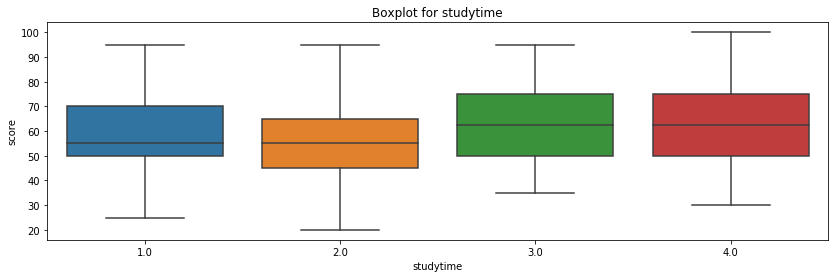

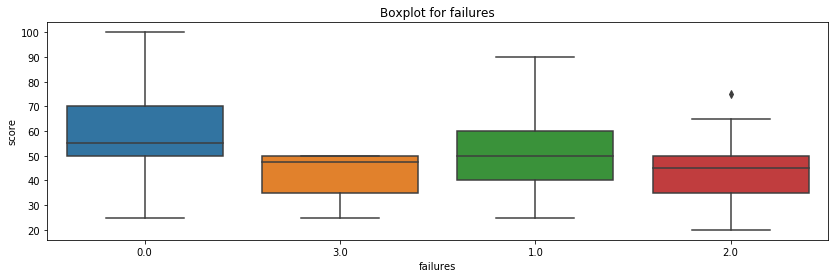

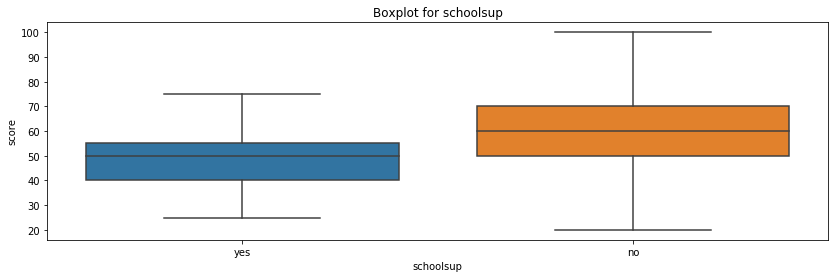

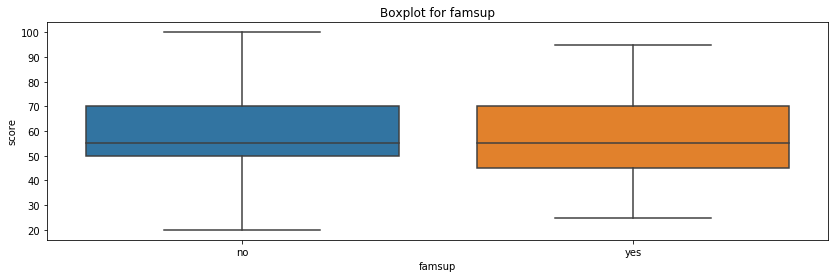

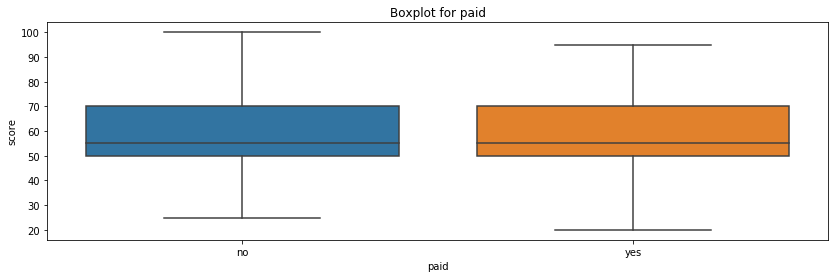

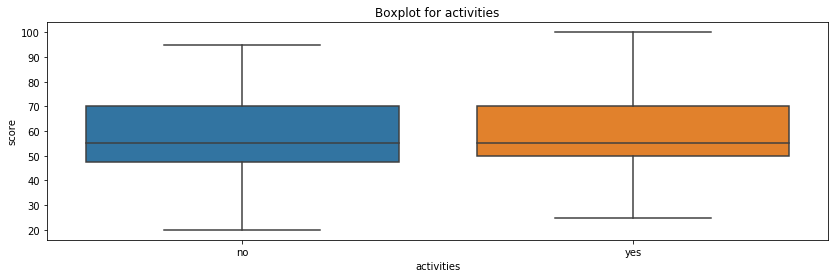

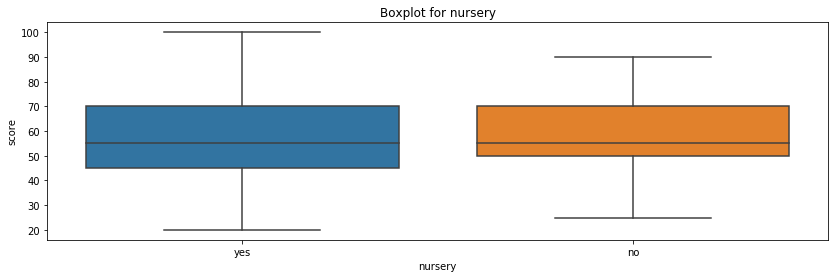

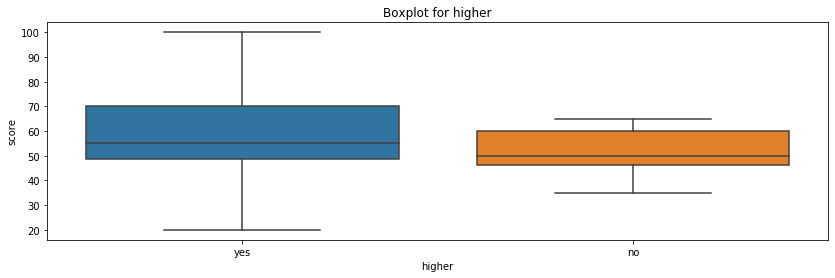

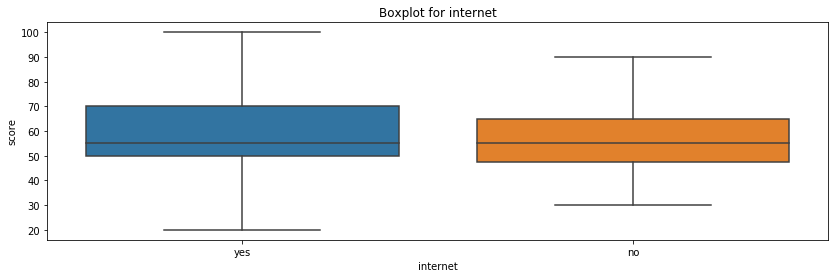

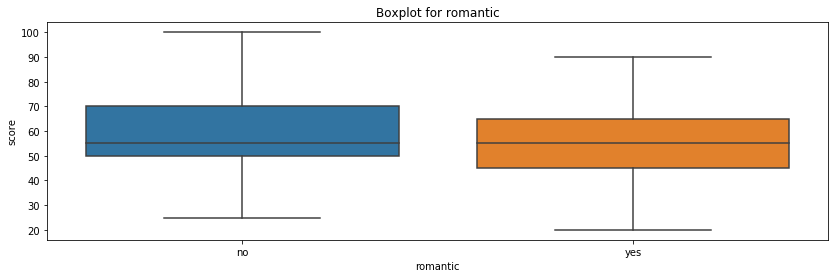

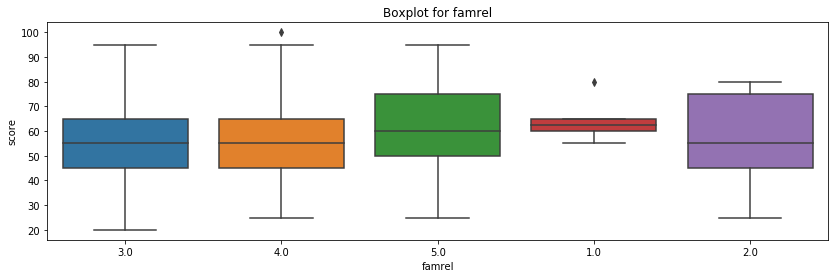

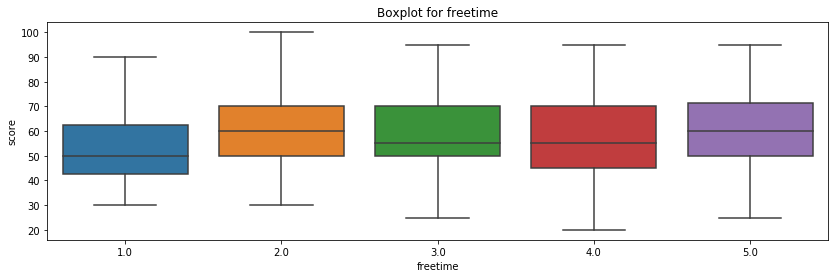

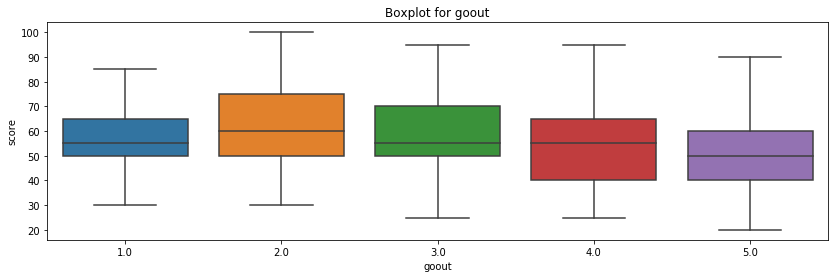

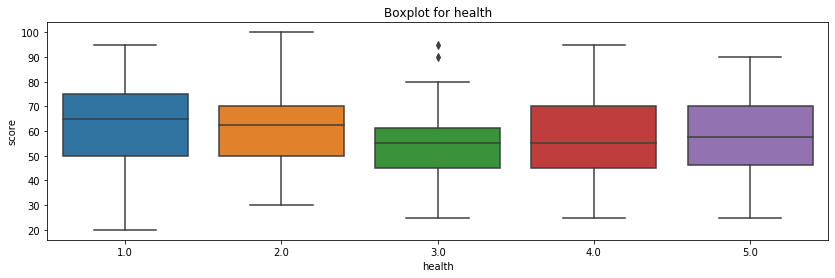

In [26]:
for col in data_nominative_columns:
    get_boxplot(col)

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределение баллов за экзамен по различным параметрам неразличимы:

In [27]:
def get_stat_dif(data,column):
    data = data.dropna(subset=[column]) ##удалим пропущенные значения в данной колонке
    cols = data[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        a = data[data[column] == comb[0]]['score']
        b = data[data[column] == comb[1]]['score']
        if (len(a)>19) & (len(b)>19):
            if ttest_ind(a,b).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
                print('Найдены статистически значимые различия для колонки', column)
                break
                
for col in data_nominative_columns:
    get_stat_dif(data,col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


Также проверим с помощью критерия Фишера:

In [28]:
def get_stat_dif_fisher(data,column):
    data = data.dropna(subset=[column]) #удалим пропущенные значения в данной колонке
    cols = data[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        a = data[data[column] == comb[0]]['score']
        b = data[data[column] == comb[1]]['score']
        if (len(a)>19) & (len(b)>19):
            if stats.f_oneway(a,b).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
                print('Найдены статистически значимые различия для колонки', column)
                break
                
for col in data_nominative_columns:
    get_stat_dif(data,col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


И с помощью непараметрического критерия Мана-Уитни:

In [29]:
from scipy.stats import mannwhitneyu

def mannwhitneyu_test(data, column):
    data = data.dropna(subset=[column]) #удалим пропущенные значения в данной колонке
    cols = data[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        a = data[data[column] == comb[0]]['score']
        b = data[data[column] == comb[1]]['score']
        if (len(a)>1) & (len(b)>1):
            if mannwhitneyu(a,b,alternative = 'two-sided').pvalue <= 0.01:
                print('Найдены статистически значимые различия для колонки', column)
                break
                
for col in data_nominative_columns:
    mannwhitneyu_test(data,col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


## Выводы
В результате EDA для анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:

В данных достаточно мало пустых значений (для большинства столбцов не более 10% от величины датасета), только столбец pstatus был заполнен в меньшем количестве случаев.

Выбросы найдены только в столбцах age, absences, famrel и fedu, что позволяет сделать вывод о том, что данные достаточно чистые.

Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это: age, sex, address, Medu, Fedu, Mjob, studytime, failures, schoolsup, goout, absences.